<a href="https://colab.research.google.com/github/jcmachicaocuf/CUF__NLP_LLM/blob/main/nlp__ind_jcmv_codigo_producto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías e instalaciones

In [ ]:
import os
ruta = 'drive/My Drive/2020 Proyectos/2020 NLP Algoritmos y Modelos/PY Indecopi NLP/data/'
archivos = os.listdir(ruta)
archivos

['bd comercio conductas.xlsx',
 'Indicadores actualizados (version 1) - copia.xlsx',
 'bd_comext_cortos.xlsx',
 'bd_indecopi_200_extracto.xlsx',
 'datatex200.csv',
 'datatex200.gsheet',
 'lista_clave.xlsx',
 'bd_vocab_comercio_hechos.xlsx',
 'tabla_conductas.xlsx',
 'bd_indc_comercio_total.xlsx',
 'indecopi_bancario_2c.xlsx',
 'data_gen',
 'bd_3gram_bancario_152020-09-01.xlsx',
 'nombres_propios.xlsx',
 'lista_top_np.xlsx',
 'lista_cond.xlsx',
 'data_graph',
 'bd_3gram_bancario_15_2020-09-07.xlsx']

In [ ]:
#!pip install spacy
!python -m spacy download es_core_news_sm

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import spacy
import es_core_news_sm
import os
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.cluster import KMeans
import numpy as np
import pickle

In [ ]:
archivos[10]

'indecopi_bancario_2c.xlsx'

In [ ]:
datatex = pd.read_excel(ruta + archivos[10])
datatex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27327 entries, 0 to 27326
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   texto_hecho  27326 non-null  object
 1   conducta     27327 non-null  object
 2   subconducta  27327 non-null  object
dtypes: object(3)
memory usage: 640.6+ KB


In [ ]:
nlp = es_core_news_sm.load()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk import ngrams
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Funciones

In [ ]:
def extrae_negaciones(texto, patrones):
  encu_tot = ''
  for pat in patrones:
    encuentra = [f.group() for f in re.finditer(pat, texto.lower())]
    for encu in encuentra:
      encu_tot += ' ' + encu
  return(encu_tot)

In [ ]:
def tokens_completos(textos, largo):
  corpusx = ' '.join(textos)
  toker = RegexpTokenizer('\w+') # le quita puntuación
  toks = toker.tokenize(corpusx.lower()) # genera tokens
  stp_es = stopwords.words('spanish') # stopwords español
  corpus_filtered = [w for w in toks if w not in stp_es and len(w) > 4] # genera corpus filtrado
  toks_df = pd.DataFrame.from_dict(Counter(corpus_filtered), orient='index')
  toks_df = toks_df.sort_values(by=[0], ascending=False)
  return(toks_df.head(largo))

In [ ]:
def corpus_filtrado(textos):
  corpusx = ' '.join(textos)
  toker = RegexpTokenizer('\w+') # le quita puntuación
  toks = toker.tokenize(corpusx.lower()) # genera tokens
  stp_es = stopwords.words('spanish') # stopwords español
  corpus_filtered = [w for w in toks if w not in stp_es and len(w) > 4] # genera corpus filtrado
  return(corpus_filtered)

In [ ]:
nlp = es_core_news_sm.load()

In [ ]:
def nombres_propios(frase):
  # requiere descargar previamente nlp como load() de spacy
  # por ejemplo nlp = es_core_news_sm.load()
  propns = []
  doc = nlp(frase)
  for tk in doc:
    if tk.pos_ == 'PROPN':
      txs = str(tk)
      propns.append(txs)
  return(propns)

In [ ]:
nombres_propios('El doctor Martínez me preguntó. Las verduras que compramos están malogradas. Las compramos en Fallabella. Parece que las traen de Arequipa')

['Martínez', 'Fallabella', 'Arequipa']

In [ ]:
def tokens_lemmas(frase):
  listado = []
  doc = nlp(frase)
  for tk in doc:
    if tk.pos_ == 'NOUN' or tk.pos_ == 'VERB':
      listado.append([str(tk).lower(), str(tk.lemma_).lower(), str(tk.pos_)])
  list_df = pd.DataFrame(listado)
  list_df.columns = ['pal', 'lema', 'gram']
  return(list_df)

In [ ]:
def comprobacion_vector(items_comunes, items_locales):
  check = []
  for it in items_comunes:
    if it in items_locales:
      check.append(1)
    else:
      check.append(0)
  return(check)

In [ ]:
def tokens_especiales(lista_tokens):
  textoz = ' '.join(lista_tokens)
  doc = nlp(textoz)
  extracto = []
  for tk in doc:
    if tk.pos_ == 'VERB' or tk.pos_ == 'NOUN':
      extracto.append(str(tk)) # append(tk.lemma_)
  extracto_f = set(extracto)
  return(extracto_f) # extracto de tokens especiales filtrados

In [ ]:
def vector_ngram(texto, lista_ngrams):
  vec = []
  for ng in lista_ngrams:
    if ng in texto.lower():
      vec.append(1)
    else:
      vec.append(0)
  return(vec)

# Operaciones

## Filtro de Base de Datos

In [ ]:
datatex.columns

Index(['texto_hecho', 'conducta', 'subconducta'], dtype='object')

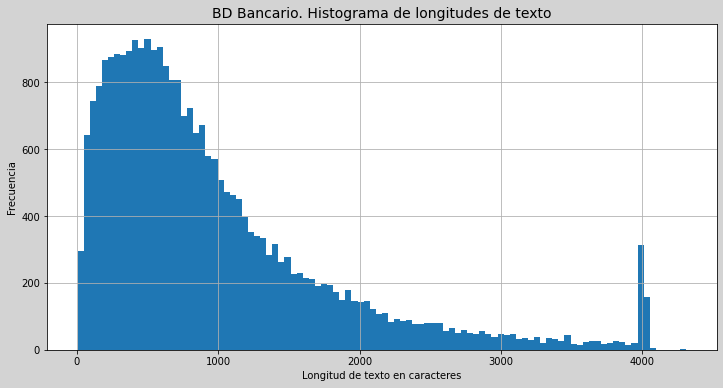

In [ ]:
plt.figure(figsize=(12,6), facecolor='lightgray')
datatex.texto_hecho.str.len().hist(bins=100)
plt.title('BD Bancario. Histograma de longitudes de texto', fontsize=14)
plt.xlabel('Longitud de texto en caracteres')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# elige las n_top_cond conductas 1 más frecuentes
n_top_cond = 30
conductas_freq = list(datatex.conducta.value_counts()[0:n_top_cond].index)
len(conductas_freq)

28

In [ ]:
datatex_f110 = datatex[datatex.conducta.isin(conductas_freq)]
datatex_f110['largo_hecho'] = datatex_f110.texto_hecho.str.len()
datatex_f120 = datatex_f110[(datatex_f110.largo_hecho < 2000) & (datatex_f110.largo_hecho > 100)]
datatex_f130 = datatex_f120[datatex_f120.conducta.str.len() > 8]
datatex_f130.head()

,texto_hecho,conducta,subconducta,largo_hecho
0,La afp profuturo nunca me hizo el deposito que...,Reportes vinculados al fondo (AFP),Reportes vinculados a AFP,266.0
1,En enero recibí una notificación de la Financi...,Cobros indebidos,Cobro de créditos vencidos o indebidos,897.0
2,por no contar con un trabajo seguro en estos m...,Reportes vinculados al fondo (AFP),Reportes vinculados a AFP,416.0
3,"Buen día soy cliente de la Tarjeta oh, de Perú...",Reprogramación de créditos,"Aplicación de intereses, comisiones u otros ca...",1302.0
4,Visualizo en mi estado de cuebta que correspon...,Reprogramación de créditos,"Aplicación de intereses, comisiones u otros ca...",629.0


In [ ]:
datax = datatex_f130

In [ ]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23249 entries, 0 to 27326
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   texto_hecho  23249 non-null  object 
 1   conducta     23249 non-null  object 
 2   subconducta  23249 non-null  object 
 3   largo_hecho  23249 non-null  float64
dtypes: float64(1), object(3)
memory usage: 908.2+ KB


In [ ]:
datax.to_pickle(ruta + 'data_gen/' + 'datatex_f120_bancario.pkl')

## Hechos. Preparación de listas generales

In [ ]:
nom_arch = 'datatex_f120_comercio_2.pkl'
datax = pd.read_pickle(ruta + 'data_gen/' + nom_arch)

In [ ]:
#@title Definición de patrones
patrones_rex = ['ni [A-Za-z0-9áéíóúñ ]+', 'no [A-Za-záéíóúñ0-9 ]+', 'nunca [A-Za-z0-9áéíóúñ ]+']

In [ ]:
#@title Extracto de palabras individuales top
textox = datax.texto_hecho
lista_tot = tokens_completos(textox, 100)
extracto_f = lista_tot.index
lista_tot.head()

,0
compra,25882
fecha,23552
entrega,17883
producto,17193
pedido,17122


In [ ]:
n = 4 #tamaño de ngram

In [ ]:
#@title Extracto de ngrams top
textox = datax.texto_hecho
texto_p = ' '.join(corpus_filtrado(textox))
texto_p = texto_p.replace('\n', ' ').lower()
n_xtracs = []
for nn in range(3,n+1):
  xtrac = ngrams(texto_p.split(), nn)
  for xt in xtrac:
    n_xtracs.append(' '.join(list(xt)))
n_xtracs_df = pd.DataFrame(Counter(n_xtracs).most_common(80))
n_xtracs_df.head(5)

,0,1
0,reclamo libro reclamaciones,945
1,fecha entrega junio,926
2,libro reclamaciones virtual,571
3,realice compra virtual,485
4,fecha entrega producto,318


## Corridas de datos el bloque

In [ ]:
# funciones diponibles
# extrae_negaciones(texto, patrones)
# tokens_completos(textos, largo_muestra_tokens)
# tokens_lemmas(frase)
# comprobacion_vector(items_comunes, items_locales)
# tokens_especiales(lista_tokens) # filtro de tokens con condiciones
# vector_ngram(texto) # entrega un vector dada una lista

In [ ]:
# parámetros generales
tx_min, tx_max = 100, 2000
reduccion = False # Optar si se saca extractos de negación o no
n_clust = 15 # define número de clusters

In [ ]:
#@title Procesamiento de Bloque Completo
# Este algoritmo usa funciones externas: extrae_negaciones(), tokens_lemmas(), comprobacion_vector()
vectores = []
conductas = []
vecs_ng = []

for j, row in datax.iterrows():

  if j % 2000 == 0:
    print(j, end=' ')

  texto = row.texto_hecho
  conducta = row.conducta

  if len(texto) < tx_max and len(texto) > tx_min:
    if reduccion:
      frasex = extrae_negaciones(texto, patrones_rex)
      lista_loc = tokens_lemmas(frasex)
    else:
      lista_loc = corpus_filtrado([texto.lower()])

    vector = comprobacion_vector(lista_tot.index, lista_loc)
    texto_stop = ' '.join(lista_loc)
    ng_vector = vector_ngram(texto_stop, n_xtracs_df[0])
    valor = np.array(ng_vector).sum()
    if valor > 0:
      conductas.append(conducta)
      vectores.append(vector)
      vecs_ng.append(ng_vector)

vectores_df = pd.DataFrame(vectores)
conductas_df = pd.DataFrame(conductas)
vecs_ng_df = pd.DataFrame(vecs_ng)

6000 8000 10000 12000 14000 16000 20000 22000 26000 30000 32000 36000 42000 

In [ ]:
print('VectoresPalabras', len(vectores_df), 'VectorConductas', len(conductas_df), 'VectorNGrams', len(vecs_ng_df))

VectoresPalabras 9097 VectorConductas 9097 VectorNGrams 9097


In [ ]:
#@title Función Gráfica
def grafica_vector_numerico(vecs_arrx, n_clust):
  X_input = np.array(vecs_arrx)
  kmeans = KMeans(n_clust, random_state=0).fit(X_input)
  vecs_arrx['clusters'] = kmeans.labels_
  vecs_arrx['jitter'] = np.random.rand(len(vecs_arrx))
  vecs_arrx['clase'] = conductas_df[0]
  vecs_arrx = vecs_arrx.dropna()
  plt.figure(figsize=(15,8), facecolor='lightgray')
  plt.plot(vecs_arrx.clusters + vecs_arrx.jitter/1.6,
           vecs_arrx.clase, 'o')

  plt.xticks(np.array([i for i in range(n_clust)]))
  plt.show()
  return(vecs_arrx)

In [ ]:
#@title Clasificabilidad de Conductas
#esta definición se puede cambiar, en adelante queda fijo vecs_arr
vecs_arr_1 = vectores_df # Opción A
vecs_arr_5 = vecs_ng_df # Opción B

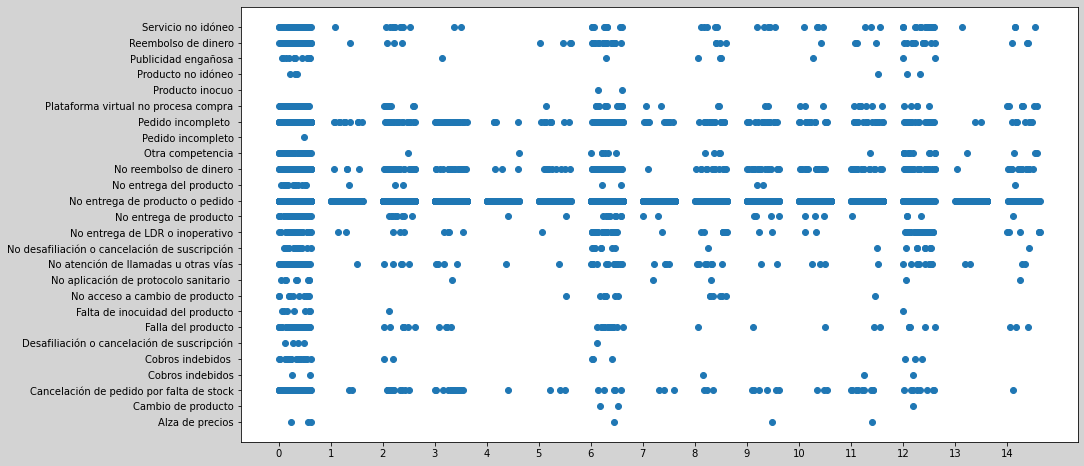

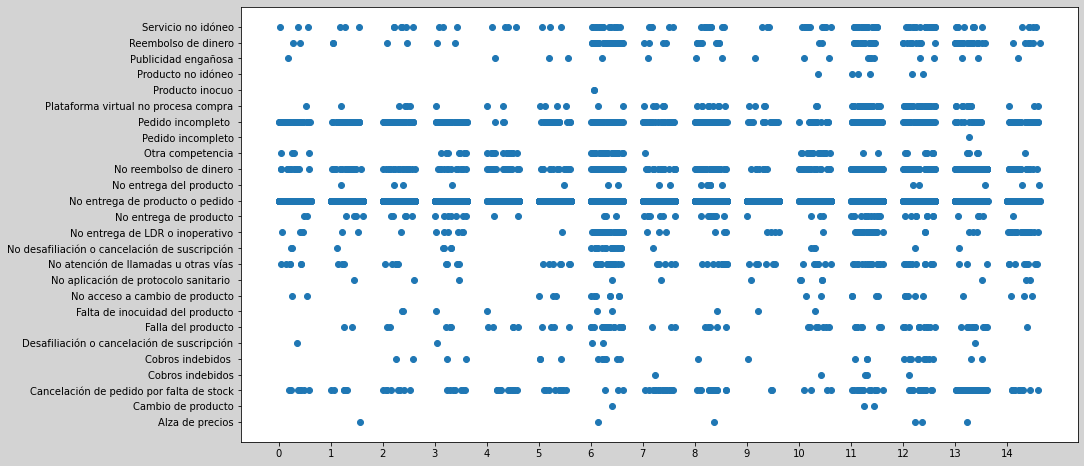

In [ ]:
vecs_arr_5a = grafica_vector_numerico(vecs_arr_5, n_clust)
vecs_arr_1a = grafica_vector_numerico(vecs_arr_1, n_clust)

## Exploración de conceptos en clusters

In [ ]:
# parámetros de gráfica
expresiones = [n_xtracs_df[0], extracto_f]
tipos = ['clase', 'clusters']
n_selec = 15
aplica_log = True

In [ ]:
#@title Frunción Gráfica Presencia de Vectores
def grafica_match(vecs_arrx, lista_expresiones, tipo):
  grupos = vecs_arrx[tipo].unique()
  v_arr_total = np.empty((0,len(lista_expresiones)))
  top_exp_tot = []
  for gru in grupos:
    tabla_grupo = vecs_arrx[vecs_arrx[tipo] == gru]
    largo_filtro = len(tabla_grupo)
    vector_conceptos = tabla_grupo.iloc[:,0:len(lista_expresiones)].sum()
    v_arr = np.array(list(vector_conceptos))/largo_filtro
    top_expr = v_arr.argsort()[-n_selec:][::-1]
    top_punt = np.sort(v_arr)[-n_selec:][::-1]
    top_exp_tot.append([gru]+[lista_expresiones[pal] for pal in top_expr] + list(top_punt))
    #print([gru]+[lista_expresiones[pal] for pal in top_expr])
    v_arr_total = np.vstack((v_arr_total, v_arr))
  #v_arr_total
  if aplica_log:
    v_arr_total[v_arr_total==0] = 0.01
    v_log = np.log(v_arr_total) #introduce logaritmos
  else:
    v_log = v_arr_total
  plt.figure(figsize=(20,15), facecolor='lightgray')
  plt.imshow(v_log, cmap='summer')
  plt.xlabel('Expresiones')
  plt.ylabel(tipo)
  plt.xticks(np.array(range(len(lista_expresiones))),
            lista_expresiones, rotation=90, fontsize=9)
  plt.yticks(np.arange(0,len(grupos)), grupos)
  plt.colorbar(fraction=0.015, pad=0.04)
  plt.savefig('grafica_'+tipo+'.png')
  plt.show()
  top_exp_tot_df = pd.DataFrame(top_exp_tot)
  return(top_exp_tot_df)

In [ ]:
from datetime import date
print(date.today())

2020-09-08


In [ ]:
ruta

'drive/My Drive/2020 Proyectos/2020 NLP Algoritmos y Modelos/PY Indecopi NLP/data/'

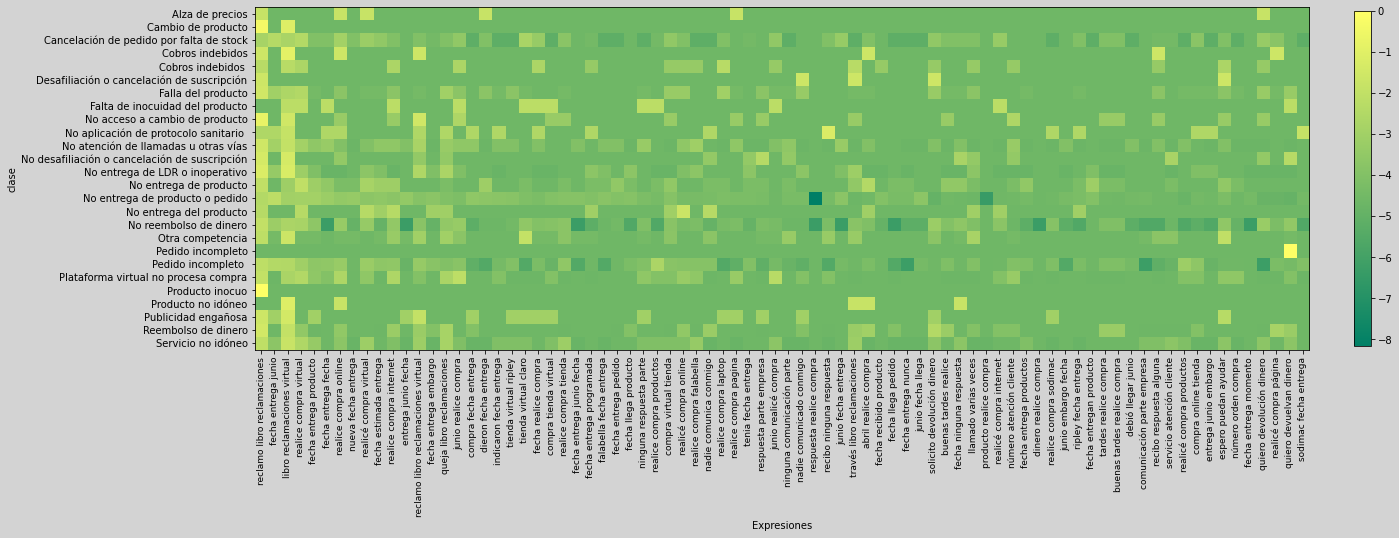

In [ ]:
#carac = 'bd_3gram_bancario_15_' # caraterizador rápido
#carac = 'bd_3gram_comercio_15_'
tabla_salida = grafica_match(vecs_arr_5a, n_xtracs_df[0], 'clase')
#tabla_salida.to_excel(ruta + 'data_gen/' + carac + str(date.today()) + '.xlsx')

In [ ]:
# Convierte la tabla en una lista de expresiones por cada clase
tabla_salida_20 = tabla_salida.iloc[:,0:16].T
tabla_salida_20.columns = list(tabla_salida_20.iloc[0,:])
tabla_salida_20 = tabla_salida_20.drop([0])
tabla_salida_20.head()

,Alza de precios,Cambio de producto,Cancelación de pedido por falta de stock,Cobros indebidos,Cobros indebidos,Desafiliación o cancelación de suscripción,Falla del producto,Falta de inocuidad del producto,No acceso a cambio de producto,No aplicación de protocolo sanitario,No atención de llamadas u otras vías,No desafiliación o cancelación de suscripción,No entrega de LDR o inoperativo,No entrega de producto,No entrega de producto o pedido,No entrega del producto,No reembolso de dinero,Otra competencia,Pedido incompleto,Pedido incompleto,Plataforma virtual no procesa compra,Producto inocuo,Producto no idóneo,Publicidad engañosa,Reembolso de dinero,Servicio no idóneo
1,reclamo libro reclamaciones,reclamo libro reclamaciones,fecha entrega junio,libro reclamaciones virtual,reclamo libro reclamaciones,reclamo libro reclamaciones,reclamo libro reclamaciones,junio realicé compra,reclamo libro reclamaciones,recibo ninguna respuesta,reclamo libro reclamaciones,reclamo libro reclamaciones,reclamo libro reclamaciones,reclamo libro reclamaciones,fecha entrega junio,realicé compra online,reclamo libro reclamaciones,libro reclamaciones virtual,quiero devuelvan dinero,reclamo libro reclamaciones,reclamo libro reclamaciones,reclamo libro reclamaciones,libro reclamaciones virtual,libro reclamaciones virtual,reclamo libro reclamaciones,libro reclamaciones virtual
2,realice compra pagina,libro reclamaciones virtual,realice compra virtual,reclamo libro reclamaciones,realice compra laptop,nadie comunicado conmigo,realice compra virtual,realice compra internet,libro reclamaciones virtual,sodimac fecha entrega,libro reclamaciones virtual,libro reclamaciones virtual,libro reclamaciones virtual,realice compra virtual,reclamo libro reclamaciones,reclamo libro reclamaciones,libro reclamaciones virtual,tienda virtual claro,sodimac fecha entrega,fecha entrega junio,junio realice compra,quiero devuelvan dinero,abril realice compra,reclamo libro reclamaciones,libro reclamaciones virtual,reclamo libro reclamaciones
3,quiero devolución dinero,ninguna respuesta parte,libro reclamaciones virtual,realice compra online,libro reclamaciones virtual,espero puedan ayudar,libro reclamaciones virtual,realice compra productos,reclamo libro reclamaciones virtual,libro reclamaciones virtual,reclamo libro reclamaciones virtual,respuesta parte empresa,reclamo libro reclamaciones virtual,abril realice compra,fecha entrega producto,realice compra virtual,realice compra virtual,espero puedan ayudar,fecha realice compra,libro reclamaciones virtual,junio realicé compra,fecha realice compra,fecha ninguna respuesta,reclamo libro reclamaciones virtual,solicito devolución dinero,realice compra virtual
4,dieron fecha entrega,compra tienda virtual,tienda virtual claro,reclamo libro reclamaciones virtual,través libro reclamaciones,solicito devolución dinero,fecha entrega junio,ninguna respuesta parte,junio realice compra,ripley fecha entrega,fecha entrega junio,quiero devuelvan dinero,queja libro reclamaciones,realicé compra virtual,realice compra virtual,realice compra internet,fecha entrega junio,reclamo libro reclamaciones,compra tienda virtual,realice compra productos,realice compra virtual,compra tienda virtual,realice compra online,espero puedan ayudar,realicé compra página,queja libro reclamaciones
5,realice compra online,realice compra tienda,reclamo libro reclamaciones,abril realice compra,realice compra virtual,través libro reclamaciones,realice compra laptop,compra tienda virtual,número atención cliente,fecha entrega junio,realice compra virtual,fecha ninguna respuesta,realice compra virtual,fecha entregan producto,libro reclamaciones virtual,realicé compra virtual,solicito devolución dinero,llamado varias veces,realice compra tienda,realice compra virtual,realice compra internet,realice compra tienda,través libro reclamaciones,compra fecha entrega,queja libro reclamaciones,realicé compra virtual


In [ ]:
lista_total_expr = []
for cols in tabla_salida_20.columns:
  lista_total_expr.extend(list(tabla_salida_20[cols]))
lista_expr_cnt = Counter(lista_total_expr)
lista_frecuente_expr = lista_expr_cnt.most_common(10)

In [ ]:
for f_exp in lista_frecuente_expr:
  print(f_exp)
  tabla_salida_20 = tabla_salida_20.replace(f_exp, 'muy frecuente')
tabla_salida_20

('reclamo libro reclamaciones', 22)
('libro reclamaciones virtual', 21)
('realice compra online', 13)
('realice compra virtual', 13)
('fecha entrega programada', 12)
('realice compra tienda', 11)
('reclamo libro reclamaciones virtual', 11)
('queja libro reclamaciones', 11)
('realicé compra virtual', 10)
('realice compra internet', 10)


,Alza de precios,Cambio de producto,Cancelación de pedido por falta de stock,Cobros indebidos,Cobros indebidos,Desafiliación o cancelación de suscripción,Falla del producto,Falta de inocuidad del producto,No acceso a cambio de producto,No aplicación de protocolo sanitario,No atención de llamadas u otras vías,No desafiliación o cancelación de suscripción,No entrega de LDR o inoperativo,No entrega de producto,No entrega de producto o pedido,No entrega del producto,No reembolso de dinero,Otra competencia,Pedido incompleto,Pedido incompleto,Plataforma virtual no procesa compra,Producto inocuo,Producto no idóneo,Publicidad engañosa,Reembolso de dinero,Servicio no idóneo
1,muy frecuente,muy frecuente,fecha entrega junio,muy frecuente,muy frecuente,muy frecuente,muy frecuente,junio realicé compra,muy frecuente,recibo ninguna respuesta,muy frecuente,muy frecuente,muy frecuente,muy frecuente,fecha entrega junio,realicé compra online,muy frecuente,muy frecuente,quiero devuelvan dinero,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente
2,realice compra pagina,muy frecuente,muy frecuente,muy frecuente,realice compra laptop,nadie comunicado conmigo,muy frecuente,muy frecuente,muy frecuente,sodimac fecha entrega,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,tienda virtual claro,sodimac fecha entrega,fecha entrega junio,junio realice compra,quiero devuelvan dinero,abril realice compra,muy frecuente,muy frecuente,muy frecuente
3,quiero devolución dinero,ninguna respuesta parte,muy frecuente,muy frecuente,muy frecuente,espero puedan ayudar,muy frecuente,realice compra productos,muy frecuente,muy frecuente,muy frecuente,respuesta parte empresa,muy frecuente,abril realice compra,fecha entrega producto,muy frecuente,muy frecuente,espero puedan ayudar,fecha realice compra,muy frecuente,junio realicé compra,fecha realice compra,fecha ninguna respuesta,muy frecuente,solicito devolución dinero,muy frecuente
4,dieron fecha entrega,compra tienda virtual,tienda virtual claro,muy frecuente,través libro reclamaciones,solicito devolución dinero,fecha entrega junio,ninguna respuesta parte,junio realice compra,ripley fecha entrega,fecha entrega junio,quiero devuelvan dinero,muy frecuente,muy frecuente,muy frecuente,muy frecuente,fecha entrega junio,muy frecuente,compra tienda virtual,realice compra productos,muy frecuente,compra tienda virtual,muy frecuente,espero puedan ayudar,realicé compra página,muy frecuente
5,muy frecuente,muy frecuente,muy frecuente,abril realice compra,muy frecuente,través libro reclamaciones,realice compra laptop,compra tienda virtual,número atención cliente,fecha entrega junio,muy frecuente,fecha ninguna respuesta,muy frecuente,fecha entregan producto,muy frecuente,muy frecuente,solicito devolución dinero,llamado varias veces,muy frecuente,muy frecuente,muy frecuente,muy frecuente,través libro reclamaciones,compra fecha entrega,muy frecuente,muy frecuente
6,muy frecuente,fecha entrega junio fecha,muy frecuente,recibo respuesta alguna,muy frecuente,fecha llega producto,muy frecuente,realicé compra internet,compra tienda virtual,fecha entrega fecha,realice compra falabella,servicio atención cliente,través libro reclamaciones,muy frecuente,fecha entrega fecha,nadie comunica conmigo,quiero devolución dinero,muy frecuente,fecha entrega junio fecha,realicé compra productos,muy frecuente,fecha entrega junio fecha,ninguna respuesta parte,realice compra laptop,abril realice compra,muy frecuente
7,fecha llega producto,muy frecuente,muy frecuente,realicé compra página,junio realice compra,compra tienda virtual,quiero devolución dinero,fecha realice compra,través libro reclamaciones,muy frecuente,ninguna respuesta parte,muy frecuente,fecha entrega junio,fecha entrega producto,nueva fecha entrega,compra virtual tienda,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,muy frecuente,nadie comunicado conmigo,buenas t

In [ ]:
tabla_salida_20.to_excel(ruta + 'data_gen/' + '_comercio_' + '_filtrado_' + str(date.today()) + '.xlsx')

In [ ]:
len(lista_expr_cnt)

69

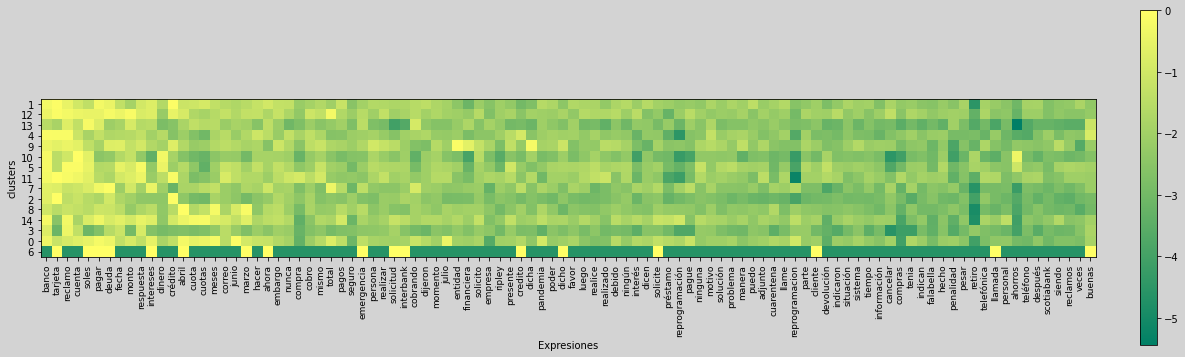

In [ ]:
tabla_salida = grafica_match(vecs_arr_1a, extracto_f, 'clusters')
tabla_salida.to_excel('tabla_salida_bancario_15_w.xlsx')

# Experimentos

In [ ]:
veck = np.array([0.1, 0.8, 0.7, 0.2, 0.9, 1.0, 0.8, 0.3])
print(np.argsort(veck)[-5:][::-1])

[5 4 6 1 2]


# TFIDF

In [ ]:
import os
ruta = 'drive/My Drive/2020 Proyectos/2020 NLP Algoritmos y Modelos/PY Indecopi NLP/data/data_gen/'
archivosx = os.listdir(ruta)
archivosx

['datatex_f120_comercio.pkl',
 'datatex_f120_comercio_2.pkl',
 'datatex_f120_bancario.pkl']

In [ ]:
import pandas as pd
datatf = pd.read_pickle(ruta + archivosx[2])

In [ ]:
datatf.texto_hecho.str.len().hist(bins=100, figsize=(12,6))

In [ ]:
datatf.shape

(16709, 4)

In [ ]:
def reduce_texto(texto):
  textoi = re.sub('[0-9]', '', texto)
  toker = RegexpTokenizer('\w+')
  toks = toker.tokenize(textoi.lower())
  stp_es = stopwords.words('spanish')
  corpus_filtered = [w for w in toks if w not in stp_es and len(w) > 4]
  return(corpus_filtered)

In [ ]:
textos_reducidos = []
for txx in datatf.texto_hecho:
  txn = ' '.join(reduce_texto(txx))
  textos_reducidos.append(txn)
datatf['texto_reducido'] = pd.Series(textos_reducidos)

In [ ]:
datatf = datatf.dropna()

In [ ]:
datatf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10459 entries, 0 to 16707
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   texto_hecho     10459 non-null  object 
 1   conducta        10459 non-null  object 
 2   subconducta     10459 non-null  object 
 3   largo_hecho     10459 non-null  float64
 4   texto_reducido  10459 non-null  object 
dtypes: float64(1), object(4)
memory usage: 490.3+ KB


In [ ]:
it_min, it_max = 0, len(datatf)
n_selec = 1000

In [ ]:
#@title Vectorización TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer

corpusx_f = list(datatf.texto_reducido[it_min:it_max])
#corpusx_f
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpusx_f)
print(X.shape)
feature_names = vectorizer.get_feature_names()
print(feature_names[0:10], len(feature_names))
print(X.shape)
Xtf = X.toarray()
print(type(Xtf), Xtf.shape)

(10459, 21610)
['a_travel_hyo', 'aadvantage', 'aaesoramiento', 'aanular', 'abajo', 'abala', 'abalan', 'abancay', 'abandonada', 'abandono'] 21610
(10459, 21610)
<class 'numpy.ndarray'> (10459, 21610)


21610
[0.20069884 0.32197948 0.19603746 ... 0.967285   4.15406478 0.34463631]
(10459, 1000)


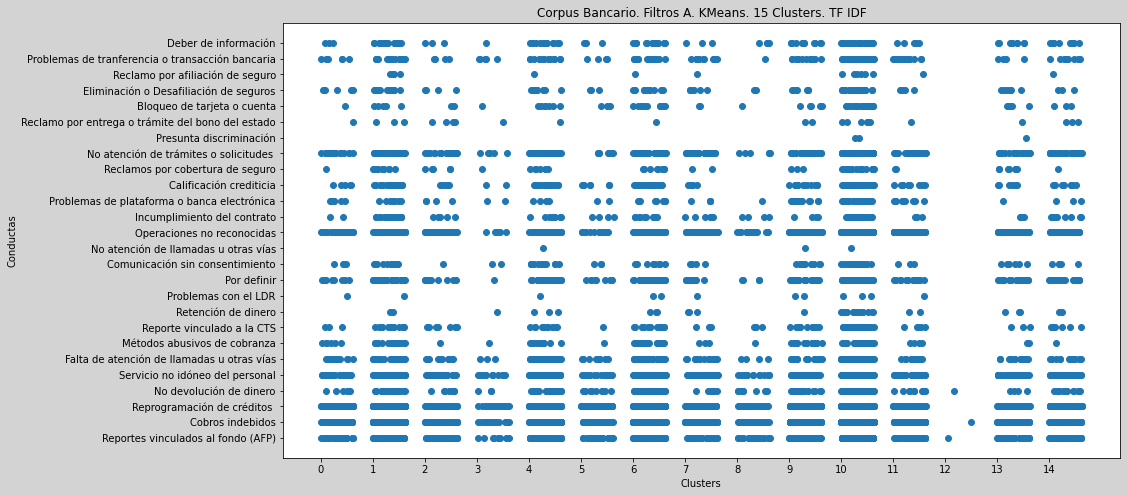

In [ ]:
#@title Gráfica TD IDF
suma_Xtf = Xtf.sum(axis=0)
print(len(suma_Xtf))
key_cols = list(suma_Xtf.argsort()[-n_selec:][::-1])
#print(suma_Xtf)
#key_cols
Xtf_sh = Xtf[:, [key_cols]]
print(Xtf_sh.shape)
from sklearn.cluster import KMeans
n_clust = 15
kmeans2 = KMeans(n_clust, random_state=0).fit(Xtf_sh)
X_df = pd.DataFrame(Xtf_sh)
vecs_df = X_df
vecs_df['cluster'] = kmeans2.labels_
vecs_df['conductas'] = list(datatf.conducta[it_min:it_max])
vecs_df['jitter'] = np.random.rand(it_max - it_min)
#vecs_df.head()
plt.figure(figsize=(15,8), facecolor='lightgray')
plt.plot(vecs_df.cluster + vecs_df.jitter/1.6, vecs_df.conductas, 'o')
plt.xticks(np.array([i for i in range(n_clust)]))
plt.title('Corpus Bancario. Filtros A. KMeans. 15 Clusters. TF IDF')
plt.xlabel('Clusters')
plt.ylabel('Conductas')
plt.show()

In [ ]:
pals = []
for k in key_cols:
  pals.append(feature_names[k])
print(len(pals))

1000


In [ ]:
vecs_arrx = vecs_df
tipo = 'conductas'
lista_expresiones = pals
grupos = vecs_arrx[tipo].unique()

In [ ]:
n_top = 20
v_arr_total = np.empty((0,len(lista_expresiones)))
top_exp_tot = []
for gru in grupos:
  tabla_grupo = vecs_arrx[vecs_arrx[tipo] == gru]
  largo_filtro = len(tabla_grupo)
  vector_conceptos = tabla_grupo.iloc[:,0:len(lista_expresiones)].sum()
  v_arr = np.array(list(vector_conceptos))/largo_filtro
  top_expr = v_arr.argsort()[-n_top:][::-1]
  top_punt = np.sort(v_arr)[-n_top:][::-1]
  top_exp_tot.append([gru]+[lista_expresiones[pal] for pal in top_expr] + list(top_punt))
  #print([gru]+[lista_expresiones[pal] for pal in top_expr])
  v_arr_total = np.vstack((v_arr_total, v_arr))

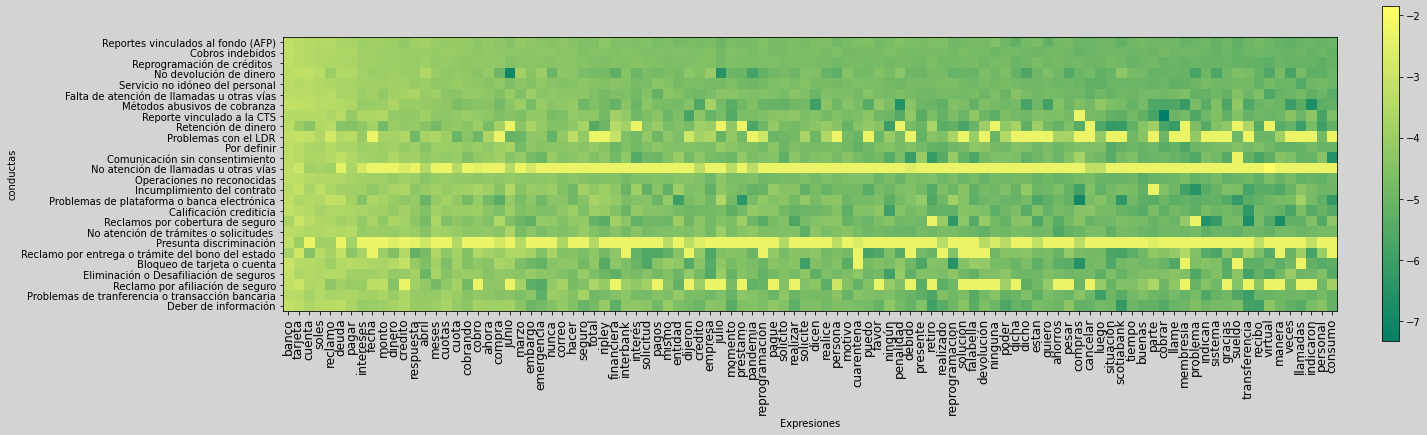

In [ ]:
ancho = 100
v_arr_total[v_arr_total==0] = 0.1
plt.figure(figsize=(20,30), facecolor='lightgray')
plt.imshow(np.log(v_arr_total[:,0:ancho]), cmap='summer')
plt.xlabel('Expresiones')
plt.ylabel(tipo)
plt.xticks(np.array(range(ancho)),
          lista_expresiones[0:ancho], rotation=90, fontsize=12)
plt.yticks(np.arange(0,len(grupos)), grupos)
plt.colorbar(fraction=0.015, pad=0.04)
#plt.savefig('grafica_'+tipo+'.png')
plt.show()
top_exp_tot_df = pd.DataFrame(top_exp_tot)

In [ ]:
top_exp_tot_df.to_excel(ruta + 'tabla_top15_bacario_w1000.xlsx')

In [ ]:
ruta

'drive/My Drive/2020 Proyectos/2020 NLP Algoritmos y Modelos/PY Indecopi NLP/data/data_gen/'

## Nombres Propios

In [ ]:
def nombres_propios(frase):
  # requiere descargar previamente nlp como load() de spacy
  # por ejemplo nlp = es_core_news_sm.load()
  propns = []
  doc = nlp(frase)
  for tk in doc:
    if tk.pos_ == 'PROPN':
      txs = str(tk)
      propns.append(txs)
  return(propns)

In [ ]:
print(len(datatex.texto_hecho))

27327


In [ ]:
lista_np_tot = []
nombres_propios_tot = []
for j, tx in enumerate(datatex.texto_hecho):

  if j%1000 == 0:
    print(j/1000, end='*')

  lista_loc = []
  try:
    txx = tx.lower()
  except:
    txx = ' '

  for np in nombres_propios(txx):
    lista_loc.append(np)
    lista_np_tot.append(np)
  nombres_propios_tot.append(','.join(lista_loc))

lista_np_tot = Counter(lista_np_tot).most_common(50)
#print(lista_np_tot)
nombresp_df = pd.DataFrame(nombres_propios_tot)
nombresp_df.head()

0.0*1.0*2.0*3.0*4.0*5.0*6.0*7.0*8.0*9.0*10.0*11.0*12.0*13.0*14.0*15.0*16.0*17.0*18.0*19.0*20.0*21.0*22.0*23.0*24.0*25.0*26.0*27.0*

,0
0,"banco,bbva,dni"
1,"cancele,oh,realice,via,pedia,habia,mas,crediticio"
2,mas
3,"oh,perú,llego,caja,piura,eh"
4,"del.monto,pedi,unero.de,reclamo,la.banca,buzon..."


In [ ]:
nombresp_df.to_excel(ruta + 'nombres_propios.xlsx')

In [ ]:
lista_np_top = pd.DataFrame(lista_np_tot)
lista_np_top.to_excel(ruta + 'lista_top_np.xlsx')